In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import mode

In [2]:
# Params

exam_in = 'benchmark_radius_100_validate_20_analysis'

range_search_mean = 50
thresould_quantile = 1.5

In [3]:
path = '/media/marcos/Dados/Projects/Results/PupilDeep'

In [4]:
path_dataset = '{}/{}'.format(path, exam_in)
dataset_list = [x for x in os.listdir(path_dataset) if '_label.csv' in x]
print(dataset_list)

['benchmark_label.csv']


In [5]:
def make_path(path):
    try:
        os.mkdir(path)
    except FileExistsError:
        pass

In [6]:
def remove_file(file):
    try:
        os.remove(file)
    except FileNotFoundError:
        pass

In [7]:
def outlier_treatment(dataset):
    Q1 = dataset['radius'].quantile(0.25)
    Q3 = dataset['radius'].quantile(0.75)
    IQR = Q3 - Q1    
    
    tq = thresould_quantile
    filter_q = (dataset['radius'] >= Q1 - tq * IQR) & (dataset['radius'] <= Q3 + tq * IQR)
    filter_q = [frame for frame, avaliable in filter_q.iteritems() if not avaliable]
    
    for frame in  filter_q:
        list_radius = np.array([])
        list_radius = dataset.loc[frame: frame+range_search_mean].radius
        dataset['radius'][frame] = int(np.median(list_radius))
    
    return dataset

In [8]:
def save_log(path_log, log):
    with open(path_log, 'a') as file_out:
        file_out.write('{}\n'.format(log))    

In [9]:
def plot_graph(dataset, path_out, title):
    img = dataset.plot.line(x='frame', y='radius', linestyle='-', markevery=100, marker='o', title=title)
    img.figure.savefig('{}/{}.pdf'.format(path_out, title))

/media/marcos/Dados/Projects/Results/PupilDeep/benchmark_radius_100_validate_20_analysis/graphs_process/benchmark_log.txt


/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


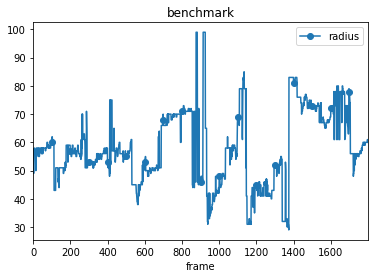

In [10]:
for file in dataset_list:
    file_in = '{}/{}'.format(path_dataset, file)
    dataset = pd.read_csv(file_in)
    #print(dataset.head())    
    
    path_out = '{}/graphs_process'.format(path_dataset)
    file_out = file.replace('_label.csv','')
    
    path_log = '{}/{}_log.txt'.format(path_out, file_out)
    
    print(path_log)
    make_path(path_out)
    remove_file(path_log)
    
    dataset = outlier_treatment(dataset)
       
    for index, item in dataset.iterrows():
        pupil_size = dataset.loc[index:index+range_search_mean].radius
        
        if len(pupil_size) <= 1:
            continue
            
        median, std, mod = np.median(pupil_size), pupil_size.std(), mode(pupil_size)[0][0]
              
        if int(item.radius) not in range(int(median-std), int(median+std)):            
            log = 'Update frame {}, radius {} for new radius {}.'.format(index, item.radius, mod)
            save_log(path_log, log)
            dataset['radius'][index] = mod
            
    plot_graph(dataset, path_out, file_out)